In [1]:
%%time
from __future__ import absolute_import, division, unicode_literals, print_function
%reload_ext autoreload
%reload_ext tensorboard
%autoreload 2

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec as gridspec
sns.set(rc={"figure.figsize":(12,10)})
sns.set_style("whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = "retina"
#np.set_print_options(precision=3,subprocess=True)

import os
import gc
gc.enable()
import sys
import csv
import json
import time
import glob
import random
import pathlib
import datetime
import functools
import subprocess
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm_notebook, tqdm

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

import sklearn
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import *

try:
  %tensorflow_version 2.x
  print("TensorFlow is up and running.")
except:
  print("Unable to run TensorFlow.")

print("Tensorflow version: ",tf.__version__)
print("Tenosrflow is executing eagerly: ", tf.executing_eagerly())
print("GPU is","available." if tf.test.is_gpu_available() else "unavaialable.")

print("Seeding...")
def seed_all(seed):
  try:
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    print("Random seeds initialized.")
  except:
    print("Uable to initialize seeds.")
seed_all(999)

from IPython.display import display, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
print(os.listdir())
print("Done.!")

TensorFlow is already loaded. Please restart the runtime to change versions.
TensorFlow is up and running.
Tensorflow version:  1.14.0
Tenosrflow is executing eagerly:  False
GPU is available.
Seeding...
Uable to initialize seeds.
['.config', 'base_clf.h5', 'model.png', 'radam_clf.h5', 'sample_data']
Done.!
CPU times: user 1.7 s, sys: 284 ms, total: 1.99 s
Wall time: 2 s


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

print(os.listdir())

['.config', 'base_clf.h5', 'model.png', 'radam_clf.h5', 'sample_data']


In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')  
validation_cats_dir = os.path.join(validation_dir, 'cats')  
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [0]:
batch_size = 64
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [0]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                        rotation_range=15,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        shear_range=0.01,
                                                                        zoom_range=[0.9, 1.25],
                                                                        horizontal_flip=True,
                                                                        vertical_flip=True,
                                                                        fill_mode='reflect',
                                                                        data_format='channels_last',
                                                                        brightness_range=[0.5, 1.5],
                                                                        validation_split=0.3)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="rgb",
                                                           batch_size=batch_size,
                                                           shuffle=True, 
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [9]:
validation_data_gen = validation_image_generator.flow_from_directory(validation_dir, 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="rgb",
                                                           batch_size=batch_size,
                                                           shuffle=True, 
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen) 

In [0]:
# plt.figure(figsize=(30,30))
# for i in range(sample_training_images.shape[0]):
#   plt.subplot(16,8,i+1)
#   plt.imshow(sample_training_images[i,:,:,:],interpolation="nearest")
#   plt.xticks([])
#   plt.yticks([])
#   plt.grid(True)
# plt.tight_layout()
# plt.show()

from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras import *

In [0]:
def create_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x) 
  predictions = Dense(1, activation='sigmoid')(x) 
  model = Model(base_model.input, predictions)
  for layer in base_model.layers:
        layer.trainable = False
  model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])
  return model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
________________________________________________________________________________

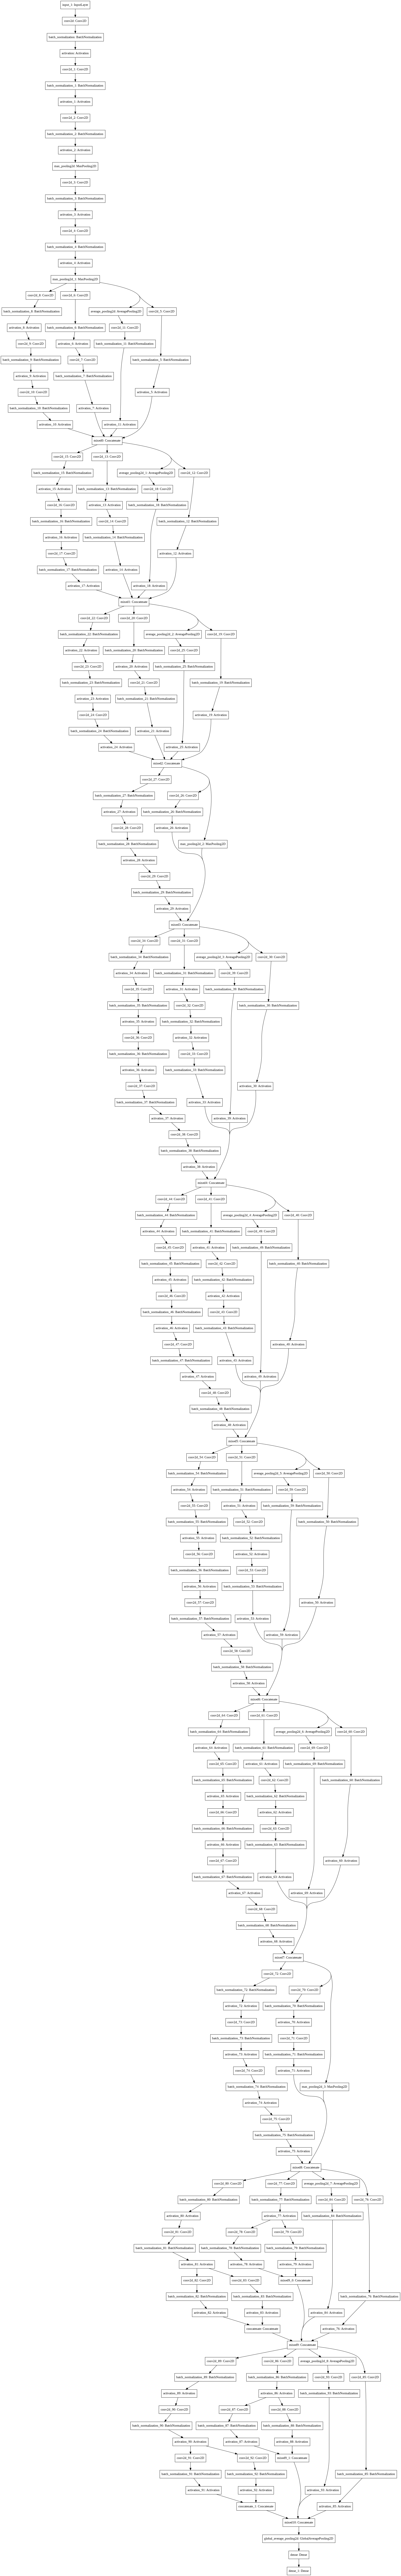

In [13]:
base_clf = create_model()
base_clf.summary()
keras.utils.plot_model(base_clf)

In [0]:
class PlotLearning(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.loss = []
    self.val_loss = []
    self.acc = []
    self.val_acc = []
    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}): 
    self.logs.append(logs)
    self.x.append(self.i)
    self.loss.append(logs.get('loss'))
    self.acc.append(logs.get('acc'))
    self.val_loss.append(logs.get('val_loss'))        
    self.val_acc.append(logs.get('val_acc'))
    self.i += 1
    f, ax = plt.subplots(1, 2, figsize=(18,10), sharex=True)
    ax = ax.flatten()
    clear_output(wait=True)
    ax[0].plot(self.x, self.loss, label="Binary Cross Entropy", lw=2)
    ax[0].plot(self.x, self.val_loss, label="Val Binary Cross Entropy")
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(self.x, self.acc, label="Accuracy", lw=2)
    ax[1].plot(self.x, self.val_acc, label="Val Accuracy")
    ax[1].legend()
    ax[1].grid(True)
    plt.show();

In [0]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.3,patience=3,verbose=1,mode="auto",min_lr=0.000001)
checkpoint = ModelCheckpoint("base_clf.h5",monitor="val_loss",verbose=1,save_best_only=True,mode="auto")
early_stopping = EarlyStopping(monitor="val_loss",patience=6,mode="auto")
plotLoss = PlotLearning()

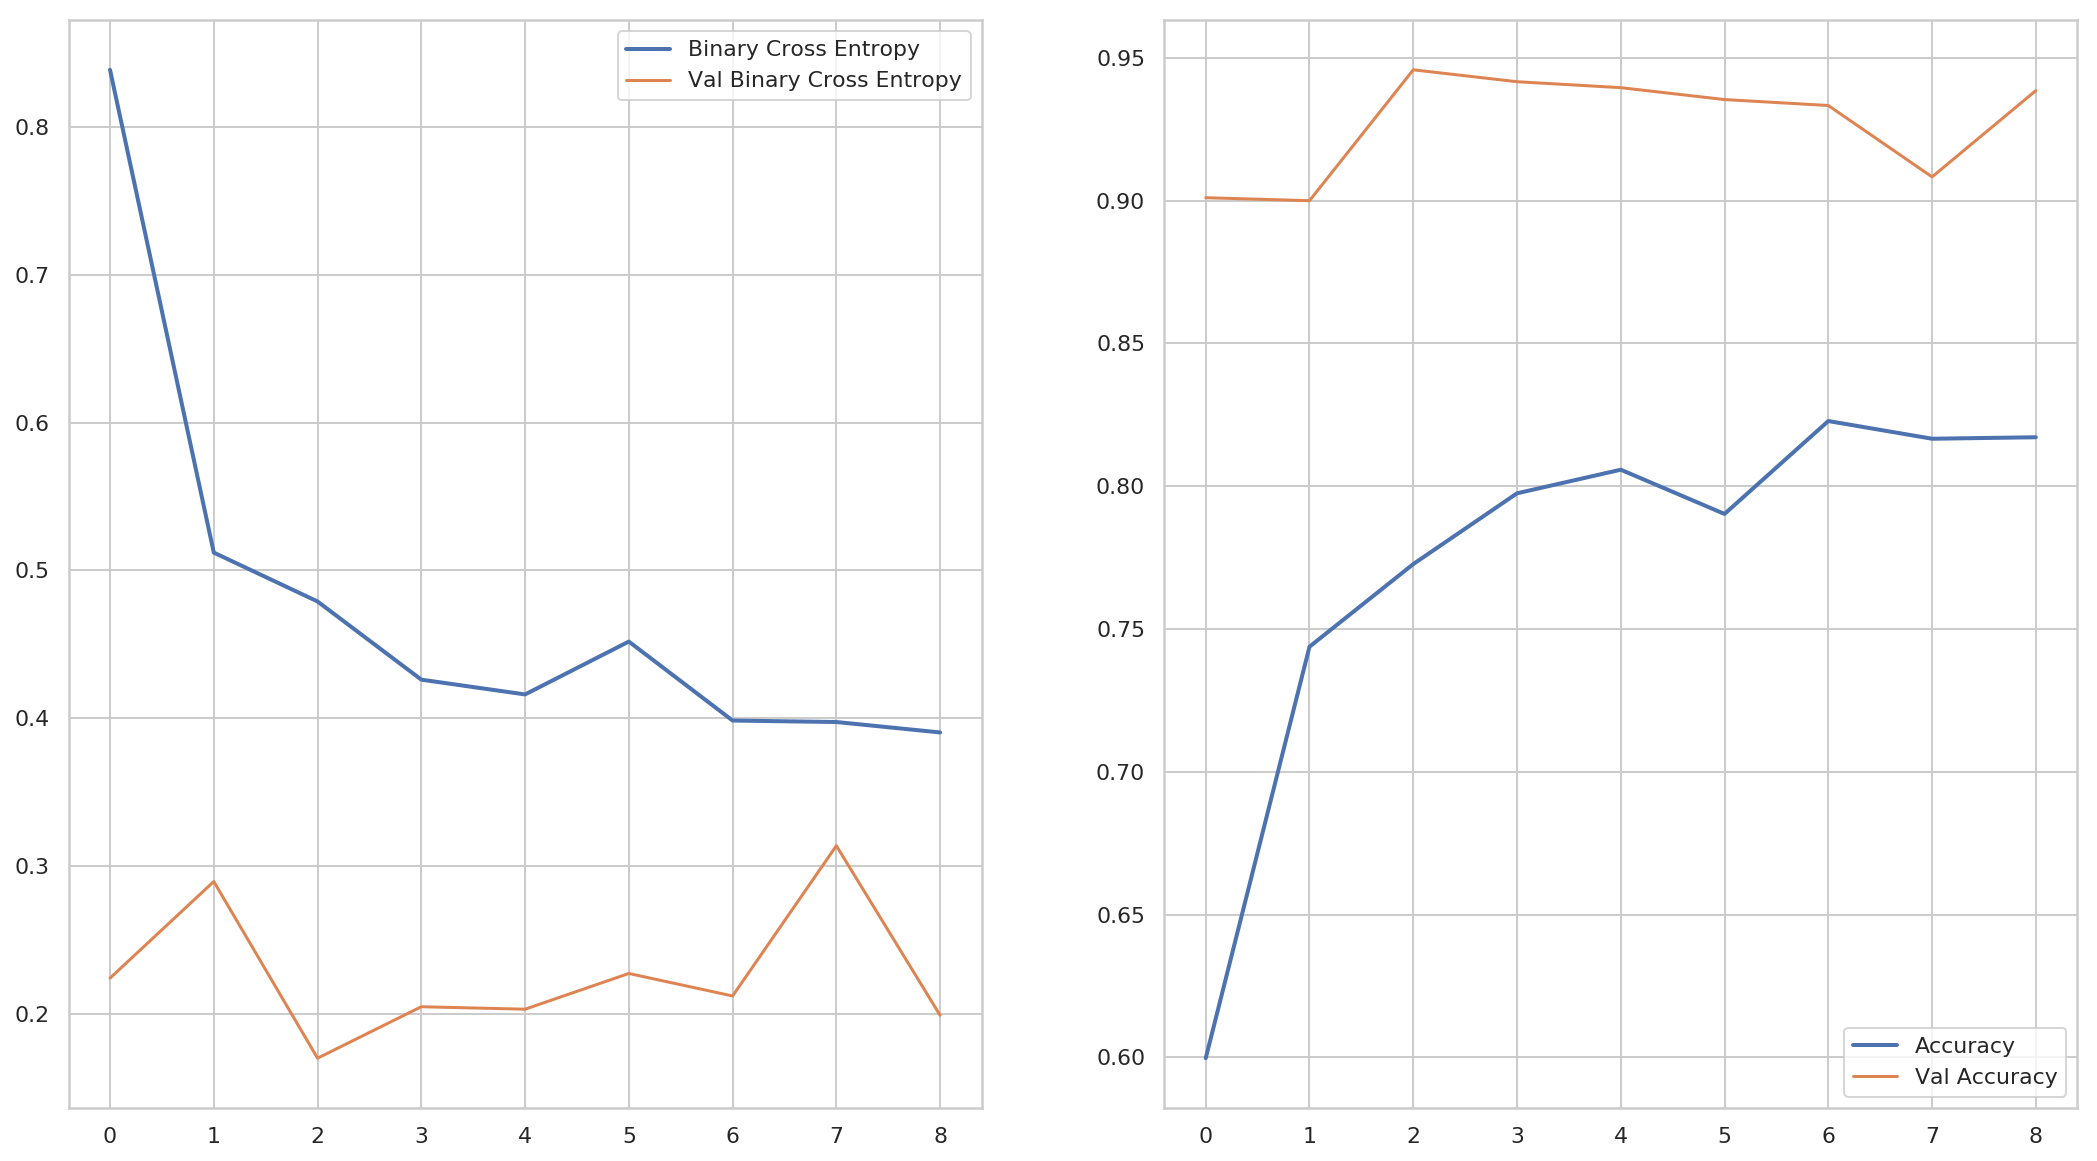

31/31 [==============================] - 22s 724ms/step - loss: 0.3879 - acc: 0.8171 - val_loss: 0.1991 - val_acc: 0.9385


In [16]:
history =  base_clf.fit_generator(train_data_gen, 
                                  steps_per_epoch=total_train//batch_size,
                                  epochs=epochs,
                                  validation_data=validation_data_gen,
                                  validation_steps=total_val // batch_size,
                                  callbacks=[reduce_lr, checkpoint, early_stopping, plotLoss])

### Using RAdam Optimizer

In [17]:
from keras.optimizers import Optimizer
from keras import backend as K


class RAdam(Optimizer):

    def __init__(self, lr, beta1=0.9, beta2=0.99, decay=0, **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.lr = K.variable(lr)
            self._beta1 = K.variable(beta1, dtype="float32")
            self._beta2 = K.variable(beta2, dtype="float32")
            self._max_sma_length = 2 / (1 - self._beta2)
            self._iterations = K.variable(0)
            self._decay = K.variable(decay)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self._iterations, 1)]
        first_moments = [K.zeros(K.int_shape(p), dtype=K.dtype(p))
                         for (i, p) in enumerate(params)]
        second_moments = [K.zeros(K.int_shape(p), dtype=K.dtype(p))
                          for (i, p) in enumerate(params)]

        self.weights = [self._iterations] + first_moments + second_moments
        bias_corrected_beta1 = K.pow(self._beta1, self._iterations)
        bias_corrected_beta2 = K.pow(self._beta2, self._iterations)
        for i, (curr_params, curr_grads) in enumerate(zip(params, grads)):
            # Updating moving moments

            new_first_moment = self._beta1 * first_moments[i] + (
                    1 - self._beta1) * curr_grads
            new_second_moment = self._beta2 * second_moments[i] + (
                    1 - self._beta2) * K.square(curr_grads)
            self.updates.append(K.update(first_moments[i],
                                         new_first_moment))
            self.updates.append(K.update(second_moments[i],
                                         new_second_moment))

            # Computing length of approximated SMA

            bias_corrected_moving_average = new_first_moment / (
                    1 - bias_corrected_beta1)
            sma_length = self._max_sma_length - 2 * (
                    self._iterations * bias_corrected_beta2) / (
                                 1 - bias_corrected_beta2)

            # Bias correction

            variance_rectification_term = K.sqrt(
                self._max_sma_length * (sma_length - 4) * (sma_length - 2) / (
                        sma_length * (self._max_sma_length - 4) *
                        (self._max_sma_length - 2) + K.epsilon()))
            resulting_parameters = K.switch(
                sma_length > 5, variance_rectification_term *
                bias_corrected_moving_average / K.sqrt(
                    K.epsilon() + new_second_moment / (1 -
                                                       bias_corrected_beta2)),
                bias_corrected_moving_average)
            resulting_parameters = curr_params - self.lr * resulting_parameters
            self.updates.append(K.update(curr_params, resulting_parameters))
        if self._decay != 0:
            new_lr = self.lr * (1. / (1. + self._decay * K.cast(
                self._iterations, K.dtype(self._decay))))
            self.updates.append(K.update(self.lr, new_lr))
        return self.updates

    def get_config(self):
        config = {
            "lr": float(K.get_value(self.lr)),
            "beta1": float(K.get_value(self._beta1)),
            "beta2": float(K.get_value(self._beta2)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [0]:
def create_radam_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x) 
  predictions = Dense(1, activation='sigmoid')(x) 
  model = Model(base_model.input, predictions)
  for layer in base_model.layers:
        layer.trainable = False
  model.compile(optimizer=RAdam(1e-4),loss="binary_crossentropy",metrics=["acc"])
  return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

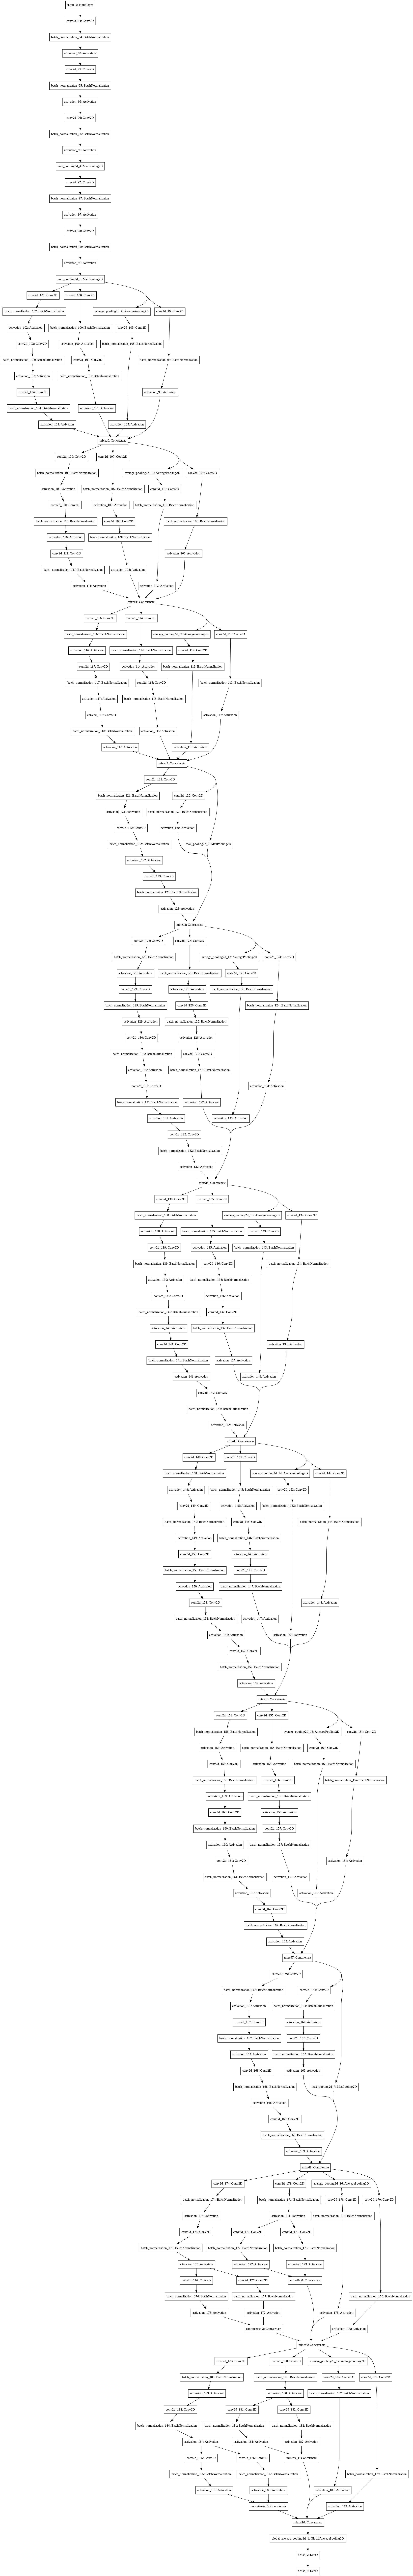

In [19]:
radam_clf = create_model()
radam_clf.summary()
keras.utils.plot_model(radam_clf)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor="loss",factor=0.3,patience=3,verbose=1,mode="auto",min_lr=0.000001)
checkpoint = ModelCheckpoint("radam_clf.h5",monitor="loss",verbose=1,save_best_only=True,save_weights_only=True,mode="auto")
early_stopping = EarlyStopping(monitor="loss",patience=10,mode="auto")
plotLoss = PlotLearning()

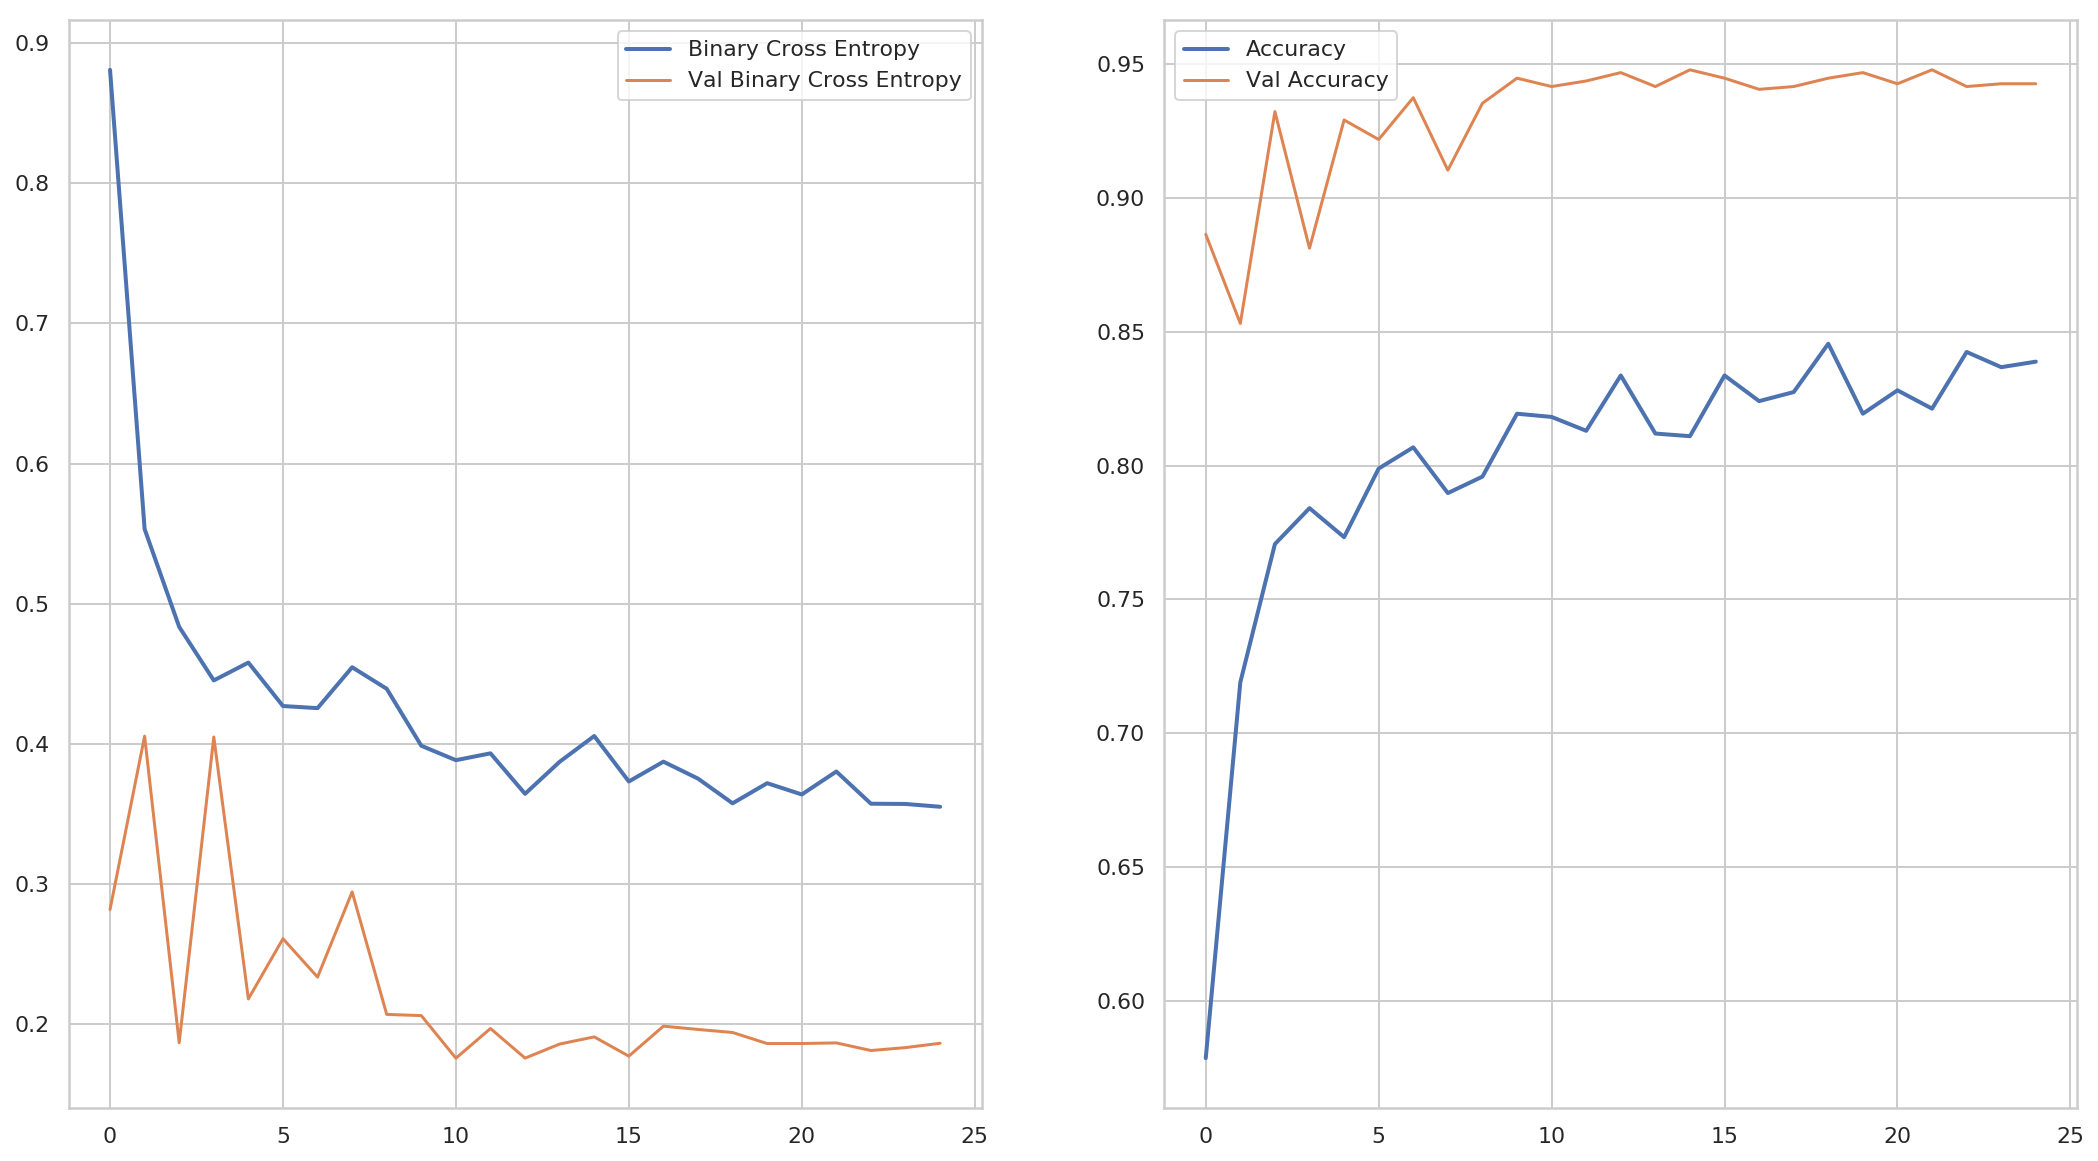

31/31 [==============================] - 22s 721ms/step - loss: 0.3626 - acc: 0.8388 - val_loss: 0.1865 - val_acc: 0.9427


In [21]:
history =  radam_clf.fit_generator(train_data_gen, 
                                  steps_per_epoch=total_train//batch_size,
                                  epochs=25,
                                  validation_data=validation_data_gen,
                                  validation_steps=total_val // batch_size,
                                  callbacks=[reduce_lr, checkpoint, early_stopping, plotLoss])